# Prediction of preterm birth

This notebook along with a r script contains the process of predicting preterm birth using whole blood gene expression data collected from pregnant women to develop prediction models for the gestational age at blood draw.


## Exploratory data analysis (EDA)

The data information is summarized below


It should contain the following files:

* `co-genes.csv`: genes expression information of 3 clustered modules from 94 most differentially expressed genes of each sample
* `anoSC2_v20_nokey.csv`: annotation information of each patient and sample including group(i.e control or preterm), train(i.e train or test data),gestational information etc.
* `geneExpression.csv`: Normalized values of RNASeq data of each sample 


In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("/Users/tianya/Desktop/CU Courses/ECBM 4060 Intro to Genomic Info/Final Project")

In [0]:
import pandas as pd

# co-genes.csv contains three eigengenes modules. 
# To create co-genes.csv, we first input the entire eset gene expression matrix and annoSC2 files into a r script
# We use limma package to find out the top 94 genes that are over-expressed in either control or preterm samples
# Then we use WGCNA package to cluster the 94 genes and combine co-expressed genes into corresponding modules
# The final results are three eigengenes, two signed and one unsigned stored in co-genes.csv
coExpr = pd.read_csv(DATA/"co-genes.csv")
coExpr = coExpr.set_index('Unnamed: 0')
coExpr.index.names = [None] 
coExpr.head()

,MEblue,MEturquoise,MEgrey
GSM1437802,0.073052,-0.000503,-0.011849
GSM1437801,0.001878,-0.022997,0.017817
GSM1437804,0.056942,0.066491,-0.044825
GSM1437803,0.052427,0.054722,-0.042404
GSM1437806,-0.018788,-0.030588,0.000516


In [0]:
# input the original eset data matrix and remove the _at suffix from row names/gene IDs
dataExpr = pd.read_csv("geneExpression.csv") 
dataExpr = dataExpr.set_index('Unnamed: 0')
dataExpr.index.names = [None] 
dataExpr = dataExpr.rename(index = lambda x: x.strip('_at'))
dataExpr.head()

,GSM1437802,GSM1437801,GSM1437804,GSM1437803,GSM1437806,GSM1437805,GSM1437808,GSM1437807,GSM1437810,GSM1437809,...,Tarca_008_P1A08,Tarca_091_P1H07,Tarca_492_P6D02,Tarca_491_P6C02,Tarca_506_P6B04,Tarca_920_P10H07,Tarca_919_P10G07,Tarca_918_P10F07,Tarca_917_P10E07,Tarca_916_P10D07
1,5.673714,5.657469,5.263798,5.621857,5.746427,5.382171,5.977089,5.771783,5.511752,5.302418,...,5.788344,5.543969,5.128486,5.343032,5.577095,5.767927,5.982427,5.869221,5.871484,5.752629
10,3.722012,3.027650,3.095365,3.429769,2.938438,3.055553,2.838617,2.977819,2.944549,2.977487,...,2.919084,2.970130,2.714327,3.012835,2.918379,2.973631,3.044613,3.321144,3.039177,2.976313
100,6.844537,6.979622,7.311993,7.406321,7.155013,6.930386,7.300295,7.156051,7.512933,7.163658,...,7.328793,7.189998,7.414430,7.559631,7.511595,7.325456,7.149270,7.130817,7.139528,7.203337
1000,4.209495,3.973889,4.126598,3.721685,3.899342,4.073817,3.811101,3.766648,4.029314,4.153578,...,3.718119,3.714274,3.902793,3.870281,3.860453,4.062084,4.034426,4.021482,3.999080,3.980084
10000,6.915998,6.820816,6.785624,6.665341,6.637787,6.552980,6.695902,6.714650,6.564450,6.640959,...,6.596466,6.693787,7.315201,7.284721,6.636553,6.501599,6.297040,6.600034,6.229878,6.284294


In [0]:
# Input the annotation file that contains group information and gestation age
annoSC2 = pd.read_csv("anoSC2_v20_nokey.csv")

In [0]:
# Split the file into test and training sets
annoSC2_train = annoSC2[annoSC2["Train"]==1]
annoSC2_test = annoSC2[annoSC2["Train"]==0]


In [0]:
annoSC2_train.head()

,SampleID,IndividualID,GA,GADel,Group,Set,Train,Platform,TTD
0,GSM1437802,515122,28.0,40.0,Control,GSE59491,1,HG21ST,12.0
1,GSM1437801,515122,19.0,40.0,Control,GSE59491,1,HG21ST,21.0
2,GSM1437804,810384,28.0,40.0,Control,GSE59491,1,HG21ST,12.0
3,GSM1437803,810384,18.0,40.0,Control,GSE59491,1,HG21ST,22.0
4,GSM1437806,810392,28.0,41.0,Control,GSE59491,1,HG21ST,13.0


In [0]:
annoSC2_test.shape

(304, 9)

In [0]:
# Split the file into test and training sets

coExpr_train = coExpr.loc[np.array(annoSC2_train["SampleID"]),:]
coExpr_test = coExpr.loc[np.array(annoSC2_test["SampleID"]),:]

In [0]:
import numpy as np

# the genes we will use from literature are EBF1, EEFSEC, AGTR2, WNT4, ADCY5, and RAP2C
# find their hugo IDs
# EBF1: 1879
# EEFSES: 60678
# AGTR2: 186
# WNT4: 54361
# ADCY5: 111
# RAP2C: 57826

top_genes = np.array(["1879", "60678", "186","54361","111","57826"])

genes_filtered = dataExpr.loc[top_genes]


# filter the genes we selected and split into test and training sets
genes_train = genes_filtered.loc[:, np.array(annoSC2_train["SampleID"])].transpose()
genes_test = genes_filtered.loc[:,np.array(annoSC2_test["SampleID"])].transpose()

In [0]:
genes_train.head()

,1879,60678,186,54361,111,57826
GSM1437802,6.360063,6.859071,2.952486,5.094788,4.737376,6.813980
GSM1437801,6.258043,7.160808,2.439917,5.132969,4.917411,6.726894
GSM1437804,5.734724,7.182273,2.638593,4.666778,4.539364,6.655620
GSM1437803,5.178100,7.037425,2.419631,4.305356,4.374173,6.776276
GSM1437806,6.236986,6.907894,2.618598,5.182926,5.081451,7.004107


In [0]:
# set the sample id to the index
annoSC2_train = annoSC2_train.set_index("SampleID")
annoSC2_test = annoSC2_test.set_index("SampleID")

In [0]:
df_train = pd.concat([annoSC2_train.loc[:,["IndividualID","GA"]],genes_train,coExpr_train], axis = 1, sort=True)
df_test = pd.concat([annoSC2_test.loc[:,["IndividualID","GA"]],genes_test,coExpr_test],axis = 1,sort=True)

In [0]:
df_train.shape

(435, 11)

In [0]:
df_test.shape

(304, 11)

In [0]:
df_train.head()

,IndividualID,GA,1879,60678,186,54361,111,57826,MEblue,MEturquoise,MEgrey
SampleID,,,,,,,,,,,
GSM1437801,515122,19.0,6.258043,7.160808,2.439917,5.132969,4.917411,6.726894,0.001878,-0.022997,0.017817
GSM1437802,515122,28.0,6.360063,6.859071,2.952486,5.094788,4.737376,6.813980,0.073052,-0.000503,-0.011849
GSM1437803,810384,18.0,5.178100,7.037425,2.419631,4.305356,4.374173,6.776276,0.052427,0.054722,-0.042404
GSM1437804,810384,28.0,5.734724,7.182273,2.638593,4.666778,4.539364,6.655620,0.056942,0.066491,-0.044825
GSM1437805,810392,18.0,6.161384,7.140457,2.462698,4.821886,4.669381,6.921162,-0.022846,-0.006927,0.008669


In [0]:
patient_count_train = df_train.groupby("IndividualID").count()[["GA"]]
patient_count_test = df_test.groupby("IndividualID").count()[["GA"]]
patient_count_train = patient_count_train.rename(columns={"GA": "no. of samples"})
patient_count_test = patient_count_test.rename(columns={"GA": "no. of samples"})

In [0]:
patient_count_train.head()

,no. of samples
IndividualID,
17516,3
18359,4
18561,3
18566,2
19116,4


In [0]:
df_train = df_train.groupby("IndividualID").max()
df_test = df_test.groupby("IndividualID").max()


In [0]:
df_train.head()

,GA,1879,60678,186,54361,111,57826,MEblue,MEturquoise,MEgrey
IndividualID,,,,,,,,,,
17516,32.4,5.873894,7.049913,2.707240,4.699407,4.650916,7.202096,0.066998,0.013157,0.012642
18359,34.1,6.516451,7.184346,2.695603,4.832905,4.782068,6.690919,0.007640,0.026830,0.054604
18561,31.6,6.081236,7.197061,2.667279,5.061835,4.788707,6.676575,-0.000442,-0.015518,0.043046
18566,30.4,5.617744,7.237615,2.710456,5.298955,5.108024,6.829965,-0.009945,-0.011258,0.040450
19116,34.1,5.986923,7.119709,2.803796,4.964592,4.758531,6.936114,0.003758,0.001380,0.071549


In [0]:
x_train = pd.concat([patient_count_train, df_train], axis = 1, sort=True)
x_test = pd.concat([patient_count_test, df_test], axis = 1, sort=True)

In [0]:
x_train.head()

,no. of samples,GA,1879,60678,186,54361,111,57826,MEblue,MEturquoise,MEgrey
IndividualID,,,,,,,,,,,
17516,3,32.4,5.873894,7.049913,2.707240,4.699407,4.650916,7.202096,0.066998,0.013157,0.012642
18359,4,34.1,6.516451,7.184346,2.695603,4.832905,4.782068,6.690919,0.007640,0.026830,0.054604
18561,3,31.6,6.081236,7.197061,2.667279,5.061835,4.788707,6.676575,-0.000442,-0.015518,0.043046
18566,2,30.4,5.617744,7.237615,2.710456,5.298955,5.108024,6.829965,-0.009945,-0.011258,0.040450
19116,4,34.1,5.986923,7.119709,2.803796,4.964592,4.758531,6.936114,0.003758,0.001380,0.071549


In [0]:
# normalize the values for ML models to perform better
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_train_norm = scaler.fit_transform(x_train)
x_train_norm = pd.DataFrame(x_train_norm, index = x_train.index, columns = x_train.columns)
x_train_norm.head()

,no. of samples,GA,1879,60678,186,54361,111,57826,MEblue,MEturquoise,MEgrey
IndividualID,,,,,,,,,,,
17516,0.333333,0.726562,0.477145,0.260105,0.286344,0.399268,0.316339,0.967796,0.770488,0.453396,0.482851
18359,0.666667,0.859375,0.917675,0.493148,0.274830,0.507739,0.447502,0.237540,0.443376,0.513781,0.701689
18561,0.333333,0.664062,0.619296,0.515189,0.246807,0.693751,0.454142,0.217050,0.398836,0.326761,0.641410
18566,0.000000,0.570312,0.301532,0.585491,0.289526,0.886418,0.773487,0.436179,0.346465,0.345577,0.627874
19116,0.666667,0.859375,0.554637,0.381098,0.381874,0.614738,0.423963,0.587821,0.421978,0.401389,0.790062


In [0]:
# create y_train(class)with one last GA samples
y_train = annoSC2_train.drop_duplicates(["IndividualID"])[["IndividualID","Group"]]
y_train = y_train.sort_values(by=["IndividualID"])
y_train = y_train.set_index("IndividualID")

In [0]:
y_train.head()

,Group
IndividualID,
17516,PPROM
18359,Control
18561,sPTD
18566,Control
19116,PPROM


<h1>Feature Importance Analysis</h1>

Use XGBoost to analyze the impact of each feature on prediction

In [0]:
y_train_multi = np.where(y_train == 'Control',0,y_train) # 0-> Control , 1 -> PPROM , 2 -> sPTD
y_train_multi = np.where(y_train_multi == 'PPROM',1,y_train_multi)
y_train_multi = np.where(y_train_multi == 'sPTD',2,y_train_multi)

In [0]:
from xgboost import XGBClassifier

model_multi = XGBClassifier()
model_multi.fit(x_train, y_train_multi)

/Users/tianya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tianya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

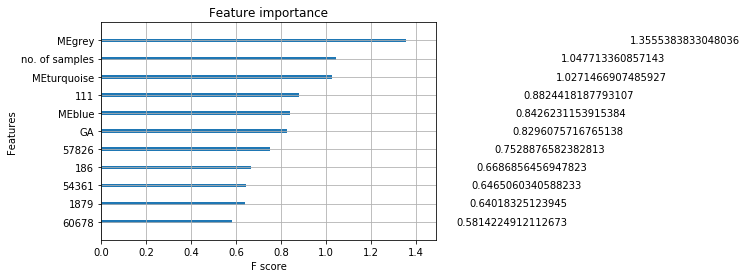

In [0]:
#Plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model_multi,importance_type='gain')
pyplot.show()
#Image will be a little too crowded to read..but the top 100 genes are stored in a list below

In [0]:
feature_imp_multi = model_multi.get_booster().get_score(importance_type='gain')

<h1>Multiclass SVC Model</h1>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
    gammas = [0.001, 0.01, 0.1, 1,10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(x_train, y_train.values.ravel(), 10)

/Users/tianya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.1}

In [0]:
# Cross validation to see the model performance
from sklearn.svm import SVC

scores = []

cv = KFold(n_splits=10, random_state=4266, shuffle=True)

for train_index, test_index in cv.split(x_train):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train = x_train.iloc[train_index]
    X_test = x_train.iloc[test_index]
    y_train2 = y_train.iloc[train_index]
    y_test = y_train.iloc[test_index]
    
    y_train2 = np.ravel(y_train2)
    
    svm = SVC(C = 10, kernel='rbf', gamma = 0.1, probability = True)
    svm.fit(X_train, y_train2)
    scores.append(svm.score(X_test, y_test))

print(scores)
print(np.mean(scores))

[0.85, 0.8, 0.75, 0.65, 0.5, 0.65, 0.6842105263157895, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579]
0.7042105263157894


In [0]:
# train the model on entire dataset
svm = SVC(C = 10, kernel='rbf', gamma = 0.1, probability = True)
svm.fit(x_train, y_train)

/Users/tianya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred = svm.predict_proba(x_test)

In [0]:
y_pred

array([[0.07431744, 0.64757304, 0.27810952],
       [0.1402476 , 0.63350728, 0.22624512],
       [0.80922399, 0.14458059, 0.04619542],
       [0.02334791, 0.60676286, 0.36988924],
       [0.87030272, 0.09760006, 0.03209722],
       [0.51422392, 0.17566083, 0.31011525],
       [0.0165272 , 0.56936545, 0.41410735],
       [0.01420442, 0.45633642, 0.52945915],
       [0.10826357, 0.65188738, 0.23984905],
       [0.16869866, 0.60334414, 0.22795719],
       [0.14318067, 0.62692351, 0.22989582],
       [0.07468862, 0.50091445, 0.42439693],
       [0.07475131, 0.49823801, 0.42701069],
       [0.70207228, 0.20126267, 0.09666505],
       [0.01250325, 0.62002377, 0.36747298],
       [0.84643663, 0.11949396, 0.03406942],
       [0.1270896 , 0.63793258, 0.23497782],
       [0.07703475, 0.6648929 , 0.25807236],
       [0.08782728, 0.66239799, 0.24977474],
       [0.80861412, 0.13134395, 0.06004193],
       [0.01986234, 0.60160729, 0.37853037],
       [0.69979558, 0.17551603, 0.12468839],
       [0.

In [0]:
svm.classes_

array(['Control', 'PPROM', 'sPTD'], dtype=object)

In [0]:
pred_df = pd.DataFrame({
    "IndividualID": x_test.index.values,
    "sPTD": y_pred[:,2],
    "PPROM": y_pred[:,1]
})

pred_df.head()

In [0]:
pred_df.to_csv(DATA/"preterm_birth_1.csv",index=False)